# Reproducing xhlulu repro
Lets start with something serious...
<a href='https://www.kaggle.com/xhlulu/satellite-clouds-u-net-with-resnet-encoder?scriptVersionId=19690388'>Link</a>

In [1]:
%config IPCompleter.use_jedi = False

In [37]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import keras
from keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv('../data/raw/train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [4]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4.0
1885,562f80a.jpg,4.0
3260,944f10b.jpg,4.0
1872,55b539f.jpg,4.0
4464,cdf7242.jpg,4.0


In [5]:
sub_df = pd.read_csv('../data/raw/sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [6]:
test_imgs.shape

(3698, 1)

In [7]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [8]:
def load_grayscale(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=-1)
    return img

def load_rgb(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.
    return img

In [9]:
sample = '0011165.jpg'

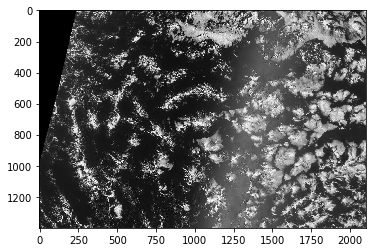

In [10]:
img_path = '../data/raw/train_images/{}'.format(sample)
img = load_grayscale(img_path)
plt.imshow(img[:, :, 0], cmap='gray')

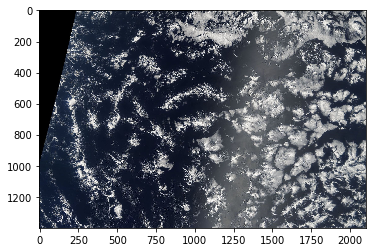

In [11]:
img_path = '../data/raw/train_images/{}'.format(sample)
img = load_rgb(img_path)
plt.imshow(img)

In [12]:
classes_sample = train_df[(train_df.ImageId == sample) & train_df.hasMask]
classes_sample

,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True


In [13]:
rle = classes_sample.EncodedPixels.iloc[0]
rle[:100]

'264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937 2'

In [14]:
mask = rle2mask(rle, img.shape)
print(img.shape)
print(mask.shape)
print(np.sum(mask))
print(np.unique(mask))

(1400, 2100, 3)
(1400, 2100)
932312
[0 1]


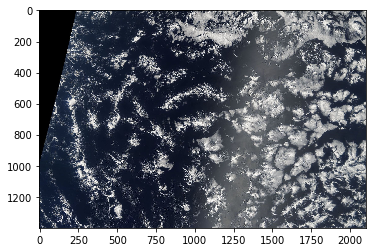

In [15]:
plt.imshow(img)
plt.show()

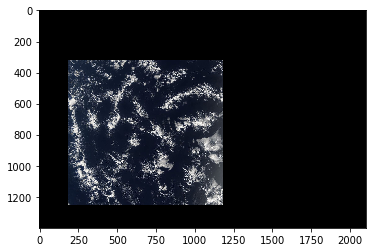

In [16]:
img_c = img.copy()
img_c[mask == 0] = 0
plt.imshow(img_c)
plt.show()

In [17]:
rle = classes_sample.EncodedPixels.iloc[1]
rle[:100]

'1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1'

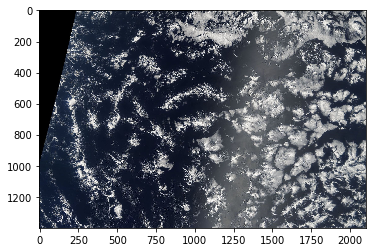

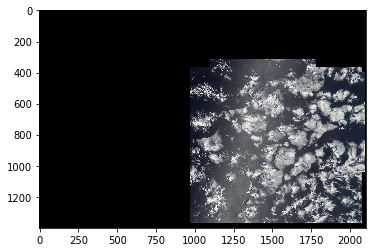

In [18]:
mask = rle2mask(rle, img.shape)
plt.imshow(img)
plt.show()
img_c = img.copy()
img_c[mask == 0] = 0
plt.imshow(img_c)
plt.show()

In [19]:
mask = rle2mask(rle, img.shape)
rle1 = mask2rle(mask)
rle1 == rle

False

In [20]:
len(rle) == len(rle1)

True

In [21]:
print(rle[:40])
print(rle1[:40])

1355565 1002 1356965 1002 1358365 1002 1
1355566 1002 1356966 1002 1358366 1002 1


In [22]:
print(rle[-40:])
print(rle1[-40:])

 644 2929196 644 2930596 644 2931996 644
 644 2929197 644 2930597 644 2931997 644


In [23]:
mask2rle(np.array([[1, 1], [1, 1]]))

'1 4'

In [24]:
rle2mask('1 4', (2, 2))

array([[0, 1],
       [1, 1]], dtype=uint8)

In [31]:
composition = albu.Compose([
    albu.HorizontalFlip(), 
    albu.VerticalFlip(),
    albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
])
composed = composition(image=img, mask=mask)
aug_img = composed['image']
aug_masks = composed['mask']

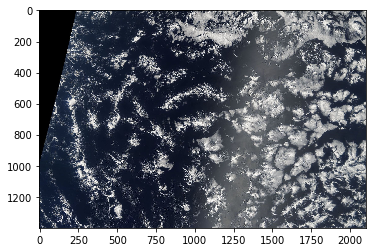

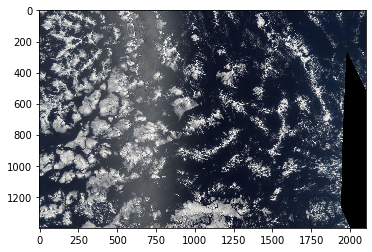

In [34]:
plt.imshow(img)
plt.show()
plt.imshow(aug_img)
plt.show()

In [66]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../data/raw/train_images',
                 batch_size=32, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=30, shift_limit=0.1)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

In [67]:
indices = np.arange(10)
print(indices)
np.random.seed(12)
np.random.shuffle(indices)
print(indices)

[0 1 2 3 4 5 6 7 8 9]
[5 8 7 0 4 9 3 2 1 6]


In [68]:
BATCH_SIZE = 32

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)

print(mask_count_df.index.shape)
print(train_idx.shape)
print(val_idx.shape)

(5546,)
(4436,)
(1110,)


In [69]:
train_generator = DataGenerator(
    train_idx, #list_ID
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(320, 480),
    augment=True,
    n_channels=3,
    n_classes=4
)

In [70]:
r = train_generator[0]

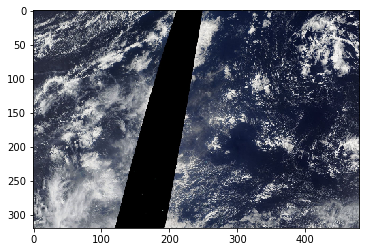

In [86]:
plt.imshow(r[0][0])
plt.show()

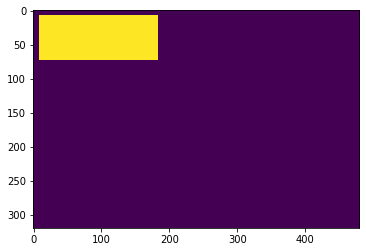

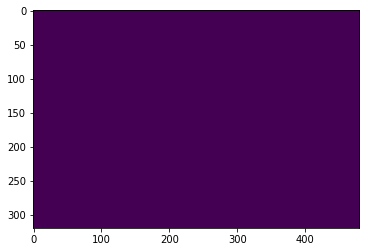

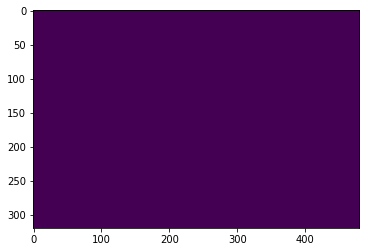

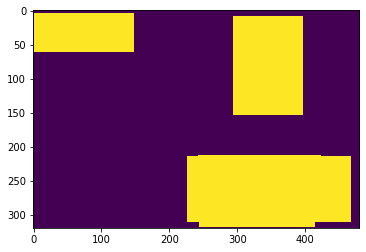

In [91]:
plt.imshow(r[1][0,:,:,0])
plt.show()
plt.imshow(r[1][0,:,:,1])
plt.show()
plt.imshow(r[1][0,:,:,2])
plt.show()
plt.imshow(r[1][0,:,:,3])
plt.show()

In [80]:
m = (1, 213)

In [82]:
type(m.count)

builtin_function_or_method

In [74]:
len(r[0][0])

320

In [78]:
r[1][1].shape

(320, 480, 4)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
